In [ ]:
# saved DF structure
'''
{0.1: {'seeds':random_seeds,
        'av_train_losses': [list of av train loss per epoch across the 5 runs len = [1,50],
        'av_val_losses': [list of av val loss per epoch across the 5 runs len = [1,50],
        'av_train_acc':[list of av train acc per epoch across the 5 runs len = [1,50],
        'av_val_acc':[list of av val acc per epoch across the 5 runs len = [1,50],
        'all_train_losses':[epoch_train_losses_by_run, shape is [5, 50]],
        'all_val_losses':[ epoch_val_losses_by_run, shape is [5, 50]],
        'all_train_accuracies':[epoch_train_accuracies_by_run, shape is [5, 50]],
        'all_val_accuracies':[epoch_val_accuracies_by_run], shape is [5, 50]},
0.01: {'seeds':random_seeds,
        'av_train_losses': average_train_losses,
        'av_val_losses': average_val_losses,
        'av_train_acc': average_train_accuracies,
        'av_val_acc': average_val_accuracies,
        'all_train_losses':epoch_train_losses_by_run,
        'all_val_losses': epoch_val_losses_by_run,
        'all_train_accuracies': epoch_train_accuracies_by_run,
        'all_val_accuracies': epoch_val_accuracies_by_run},
        
        ....}

'''


# 1. imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json
import importlib
import math



try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm
import utils
from utils import *

# importlib.reload(utils)


# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 3. checking environment 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False
print(f"IN_COLAB= {IN_COLAB}")

# 4. get the data for the task (for baseline, no transforms applied, simple train/test split used)
# This is the equivalent of building an instance of the pytorch 'Dataset' class using the CIFAR dataset 
# Each dataset can be indexed into and each individual sample is a tuple of the form (image, target) where target is index of the target class ref https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10.
# a simple train/test split 

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
#EX 1
# 1.1 - Use average performance of each LR to plot training and validation data for each LR
# 1.2 - plot average performance of a model using learning rate scheduler

# 1.3 - using LR scheduler model AND best performing non-LR scheduled model COMPARE THEM
    # - PLOT comparison of their train/validation gaps
    # - COMPARE test performance

In [ ]:
# EXPERIMENT 1.1 - Diff Learning rates

num_epochs = 35
random_seeds = list(range(5))
learning_rates_for_experiment = [0.1, 0.01, 0.001, 0.0001]
averaged_results = {lr:{} for lr in learning_rates_for_experiment}
path_to_save = f'./run_data/learning_rates/corrected_lr_data_{num_epochs}_epochs.json'
path_to_load = f'./run_data//learning_rates/corrected_lr_data_{num_epochs}_epochs.json'
save_experiment = True

for learning_rate in learning_rates_for_experiment:
    print('LR: ', learning_rate) 
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
       
    for random_seed in random_seeds:
        print('lr: ', learning_rate) 
        print('seed:', random_seed)
        model = BaselineNet(random_seed).to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)

        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=False)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[learning_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
            

In [ ]:
# from utils import display_accuracy_heatmap, plot_all_models_performance_from_disk

# # visualise results
# results_path = 'run_data/lr_data_35_epochs.json'
# display_accuracy_heatmap(results_path)
# plot_all_models_performance_from_disk(results_path, enforce_axis_range=True)


In [ ]:
# Experiment 1.2 - LR decay
def adjust_learning_rate(optimiser, epoch, initial_lr=0.15, decay_rate=0.25):    
    new_lr = initial_lr / (1 + decay_rate *epoch)
    for param_group in optimiser.param_groups:
        param_group['lr'] = new_lr
    print('LR:',new_lr)
    return optimiser

num_epochs = 50
learning_rate = 0.15

random_seeds = list(range(5))
decay_rate = 0.25
averaged_results = {decay_rate:{}}
path_to_save = f'./run_data/lr_decay/corrected_decaying_lr_just_decay_data_{num_epochs}_epochs_init_lr_0_15dr_0_25.json'
path_to_load = f'./run_data/lr_decay/corrected_decaying_lr_just_decay_data_{num_epochs}_epochs_init_lr_0_15dr_0_25.json'
save_experiment = True

  
epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []
    
for random_seed in random_seeds:
    print('DECAY: ', decay_rate)
    print('seed:', random_seed)
    torch.manual_seed(random_seed)

    model = BaselineNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=learning_rate)

    model,train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, train_report,val_report = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=True, scheduler_func=adjust_learning_rate, plot=True)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)

    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[decay_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=5, title=f'DECAY: {decay_rate}')
    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
        
        


In [ ]:
# Experiment 1.2 - LR decay
def adjust_learning_rate(optimiser, epoch, initial_lr=0.1, decay_rate=0.75):    
    new_lr = initial_lr / (1 + decay_rate *epoch)
    for param_group in optimiser.param_groups:
        param_group['lr'] = new_lr
    print('LR:',new_lr)
    return optimiser

num_epochs = 50
learning_rate = 0.15

random_seeds = list(range(5))
decay_rate = 0.25
averaged_results = {decay_rate:{}}
path_to_save = f'./run_data/lr_decay/corrected_decaying_lr_just_decay_data_{num_epochs}_epochs_init_lr_0_1dr_0_75.json'
path_to_load = f'./run_data/lr_decay/corrected_decaying_lr_just_decay_data_{num_epochs}_epochs_init_lr_0_1dr_0_75.json'
save_experiment = True

  
epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []
    
for random_seed in random_seeds:
    print('DECAY: ', decay_rate)
    print('seed:', random_seed)
    torch.manual_seed(random_seed)

    model = BaselineNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=learning_rate)

    model,train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, train_report,val_report = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=True, scheduler_func=adjust_learning_rate, plot=True)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)

    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[decay_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=5, title=f'DECAY: {decay_rate}')
    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
        

In [ ]:
# exp 2 prep

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 25000
num_train_samples = len(train_data) - num_validation_samples
train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# EXPERIMENT 2
# 2.1.1 - plot VAL/TRAINING gap for each drop out rate
# 2.1.2- evaluate on test set for each too

Epoch [21/100] - Train Loss: 1.2255, Acc: 0.5649 | Val Loss: 1.2030, Acc: 0.5681
Epoch [22/100] - Train Loss: 1.1973, Acc: 0.5745 | Val Loss: 1.1605, Acc: 0.5839
Epoch [23/100] - Train Loss: 1.1808, Acc: 0.5774 | Val Loss: 1.1439, Acc: 0.5883
Epoch [24/100] - Train Loss: 1.1542, Acc: 0.5888 | Val Loss: 1.1254, Acc: 0.6011
Epoch [25/100] - Train Loss: 1.1326, Acc: 0.5998 | Val Loss: 1.1178, Acc: 0.6028
Epoch [26/100] - Train Loss: 1.1065, Acc: 0.6059 | Val Loss: 1.0942, Acc: 0.6062
Epoch [27/100] - Train Loss: 1.0838, Acc: 0.6176 | Val Loss: 1.0893, Acc: 0.6095
Epoch [28/100] - Train Loss: 1.0629, Acc: 0.6254 | Val Loss: 1.0940, Acc: 0.6140
Epoch [29/100] - Train Loss: 1.0397, Acc: 0.6303 | Val Loss: 1.0218, Acc: 0.6419
Epoch [30/100] - Train Loss: 1.0151, Acc: 0.6436 | Val Loss: 1.0280, Acc: 0.6326
Epoch [31/100] - Train Loss: 0.9997, Acc: 0.6476 | Val Loss: 1.0114, Acc: 0.6402
Epoch [32/100] - Train Loss: 0.9816, Acc: 0.6521 | Val Loss: 1.0172, Acc: 0.6421
Epoch [33/100] - Train Loss:

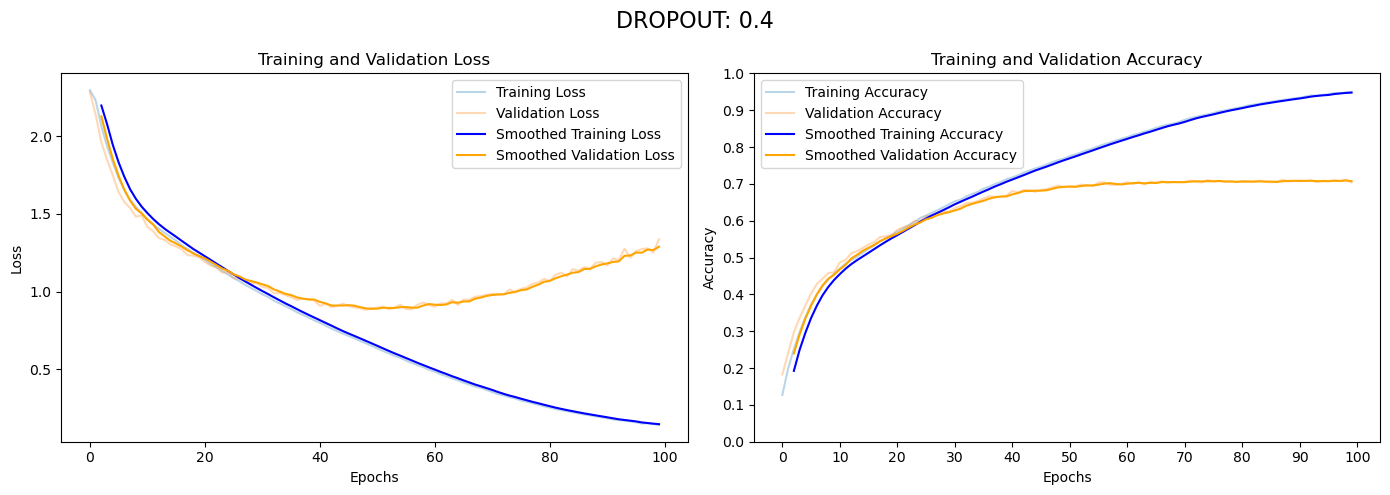

DR:  0.6
DR:  0.6
seed: 0
Epoch [1/100] - Train Loss: 2.2973, Acc: 0.1148 | Val Loss: 2.2869, Acc: 0.1719
Epoch [2/100] - Train Loss: 2.2508, Acc: 0.1834 | Val Loss: 2.1645, Acc: 0.2259
Epoch [3/100] - Train Loss: 2.1023, Acc: 0.2241 | Val Loss: 2.0007, Acc: 0.2831
Epoch [4/100] - Train Loss: 1.9947, Acc: 0.2640 | Val Loss: 1.8919, Acc: 0.3268
Epoch [5/100] - Train Loss: 1.8945, Acc: 0.3041 | Val Loss: 1.8095, Acc: 0.3526
Epoch [6/100] - Train Loss: 1.8035, Acc: 0.3430 | Val Loss: 1.6864, Acc: 0.3917
Epoch [7/100] - Train Loss: 1.7364, Acc: 0.3644 | Val Loss: 1.6244, Acc: 0.4129
Epoch [8/100] - Train Loss: 1.6740, Acc: 0.3900 | Val Loss: 1.5736, Acc: 0.4338
Epoch [9/100] - Train Loss: 1.6348, Acc: 0.4045 | Val Loss: 1.5300, Acc: 0.4352
Epoch [10/100] - Train Loss: 1.5969, Acc: 0.4194 | Val Loss: 1.4838, Acc: 0.4541
Epoch [11/100] - Train Loss: 1.5669, Acc: 0.4296 | Val Loss: 1.4749, Acc: 0.4663
Epoch [12/100] - Train Loss: 1.5336, Acc: 0.4405 | Val Loss: 1.4294, Acc: 0.4778
Epoch [13/1

KeyboardInterrupt: 

In [3]:
# exp 2 pt 1 - drop out exploration
from utils import DropoutNet
num_epochs = 100
learning_rate = 0.01
random_seeds = list(range(5))
dropout_rates_for_experiment = [0, 0.2, 0.4, 0.6, 0.8]
averaged_results = {dr:{} for dr in dropout_rates_for_experiment}

path_to_save = f'./run_data/dropout/corrected_dropout_data_{num_epochs}_epochs.json'
path_to_load = f'./run_data/dropout/corrected_dropout_data_{num_epochs}_epochs.json'
save_experiment = True


for dropout_rate in dropout_rates_for_experiment:
    print('DR: ', dropout_rate) 
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
    
    for random_seed in random_seeds:
        print('DR: ', dropout_rate) 
        print('seed:', random_seed)
        torch.manual_seed(random_seed)

        model = DropoutNet(dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)

        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, metrics = False, manual_lr_schedule=False)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
        
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[dropout_rate] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    print('average for ')
    print('DR: ', dropout_rate) 
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'DROPOUT: {dropout_rate}')

if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
        
        


In [ ]:
# from utils import display_accuracy_heatmap, print_sep_runs_from_file
# path_to_load = f'./run_data/dropout_data_50_epochs.json'

# display_accuracy_heatmap(path_to_load)
# man_ticks =[1, 0.1, 3, 0.25]
# print_sep_runs_from_file(path_to_load, 50, manual_ticks=True, ticks=man_ticks)


In [ ]:
# EXPR 2 PART 2
# summary:
# swap the two data sets
# To swap the datasets between the two dataloaders

batch_size = 64

original_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
original_val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

swapped_train_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
swapped_val_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)




In [ ]:
# get the non-dropout model (like inialise it fresh)
# train them on original data and save them as model


best_dropout_rate = 0.6
num_epochs = 100
learning_rate = 0.1
random_seeds = list(range(5))


path_to_save = f'./run_data/dropout/corrected_dropout_model_comparison_original_data_{num_epochs}_epochs.json'
path_to_load = f'./run_data/dropout/corrected_dropout_model_comparison_original_data_{num_epochs}_epochs.json'

models = [0, 1]
averaged_results = {i:{} for i in models}

save_experiment = True

# train them both on the original data
for i, model in enumerate(models):
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
    
    for random_seed in random_seeds:
        print('MODEL: ', i) 
        print('seed:', random_seed)
        model = BaselineNet(random_seed=random_seed) if i == 0 else DropoutNet(dropout_rate=best_dropout_rate, random_seed=random_seed)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)
        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, original_train_dataloader, original_val_dataloader, metrics = False, manual_lr_schedule=False)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
        
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[i] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    print('average for ')
    print('Model: ', i) 
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'MODEL: {i}')
    
    # save last version of model to disk for retraining    
    torch.save(model, f'./models/trained_model_{i}.pth')

    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
        


In [ ]:
# LOAD THEM AS NEW MODELS FOR RETRAINING 

pretrained_model_non_dropout = torch.load('./models/trained_model_0.pth', pretrained=True)
pretrained_model_best_dropout = torch.load('./models/trained_model_1.pth', pretrained=True)


pretrained_model_non_dropout.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=128)
pretrained_model_best_dropout.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=128)


pretrained_model_non_dropout.fc2 = nn.Linear(in_features=128, out_features=10)
pretrained_model_best_dropout.fc2 = nn.Linear(in_features=128, out_features=10)

# do transfer learning

num_epochs = 50
learning_rate = 0.1
random_seeds = list(range(5))

averaged_results = {dr:{} for dr in dropout_rates_for_experiment}

path_to_save = f'./run_data/dropout/corrected_dropout_model_comparison_swapped_data_{num_epochs}_epochs.json'
path_to_load = f'./run_data/dropout/corrected_dropout_model_comparison_swapped_data_{num_epochs}_epochs.json'

models = [0, 1]
averaged_results = {i:{} for i in models}

save_experiment = True

# train them both on the swapped train and val data - test data same
for i, model in enumerate(models):
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
    
    for random_seed in random_seeds:
        print('MODEL: ', i) 
        print('seed:', random_seed)
        model = pretrained_model_non_dropout if i == 0 else pretrained_model_best_dropout
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)
        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, swapped_train_dataloader, swapped_val_dataloader, metrics = False, manual_lr_schedule=False)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
        
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[i] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    print('average for ')
    print('Model: ', i) 
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'MODEL: {i}')
    


if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read
        


In [ ]:
#2. 5 COMPARE AND CONTRAST!

# EX 3
Investigate the quality of gradient flow through your network.


*First*, for the model that does not use Dropout, record gradients for the optimised parameters (i.e.
dL/dw) in each layer of your model. 

Record the gradients over the first 5 episodes of training.
Build a separate record of gradients over the final 5 episodes of training. 
Produce plots to show how the mean and standard deviation of gradients change as a function of layer number, for both the beginning (first 5 episodes) and the end (final 5 episodes) of training.

*Second*, using the best performing, non-zero Dropout rate from Experiment 2, perform the same calculations to compute the mean and stand deviation of the gradients for all layers, and over the first and final 5 episodes of training. 
Does Dropout affect gradient flow in your model? If so, how are the gradients affected?

*Third*, without including Dropout, add batch normalisation to each hidden layer of your model.
Again, compute and plot the mean and standard deviation of the gradients as you had done before. How is gradient flow affected by batch normalisation in your model?

*Fourth*, using learning curves for training and validation data, show how batch normalisation affects the performance of your model, referring to its average performance on the test data as well as to the generalisation gap between the average training and validation learning curves

In [ ]:
batch_size = 64

torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:

num_epochs = 50
learning_rate= 0.01

torch.manual_seed(0)

non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics(last_5_epochs_gradients_non_drop)

plot_gradient_statistics(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

torch.manual_seed(0)

drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics(last_5_epochs_gradients_bn)

plot_gradient_statistics(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)


In [ ]:
num_epochs = 100
learning_rate = 0.01

random_seeds = list(range(5))


path_to_save = f'./run_data/batch_norm/batch_norm_{num_epochs}_epochs.json'
path_to_load = f'./run_data/batch_norm/batch_norm_{num_epochs}_epochs.json'

averaged_results = {'bn':{}}

save_experiment = True

# train them both on the original data

epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []

for random_seed in random_seeds:
    print('MODEL: ', i) 
    print('seed:', random_seed)
    torch.manual_seed(random_seed)
    model = BatchNormNet()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=learning_rate)
    model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, metrics = False, manual_lr_schedule=False)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)
    
average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
average_test_loss = sum(test_losses)/len(test_losses)
average_test_accuracy = sum(test_accuracies)/len(test_accuracies)

averaged_results['bn'] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                    'av_val_losses': average_val_losses,
                                    'av_train_acc': average_train_accuracies,
                                    'av_val_acc': average_val_accuracies,
                                    'all_train_losses':epoch_train_losses_by_run,
                                    'all_val_losses': epoch_val_losses_by_run,
                                    'all_train_accuracies': epoch_train_accuracies_by_run,
                                    'all_val_accuracies': epoch_val_accuracies_by_run,
                                    'all_test_losses':test_losses, 
                                    'all_test_accuracies':test_accuracies,
                                    'av_test_loss': average_test_loss,
                                    'av_test_accuracy':average_test_accuracy}
print('average for ')
print('Model: ', i) 
plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'MODEL: {i}')

    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

In [2]:
for a, b in enumerate(['a', 'b', 'c', 'd', 'e'], 1):
    print(a)
    print(b)

1
a
2
b
3
c
4
d
5
e
